In [1]:
import pandas as pd
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import xml.etree.ElementTree as ET

In [2]:
from scipy.io import loadmat

# Load the .mat file
BASE_DIR = os.getcwd() 
DATA_PATH = os.path.join(BASE_DIR, "images")

train_list_path = os.path.join(BASE_DIR, "lists/train_list.mat")
train_annotation = loadmat(train_list_path)
train_list = train_annotation['file_list']
train_list = [item[0][0] for item in train_list]

test_list_path = os.path.join(BASE_DIR, "lists/test_list.mat")
test_annotation = loadmat(test_list_path)
test_list = test_annotation['file_list']
test_list = [item[0][0] for item in test_list]

In [3]:
def parse_bounding_boxes(annotation_dir, file_list):
    records = []
    for rel_path in file_list:
        img_id = os.path.splitext(os.path.basename(rel_path))[0]
        class_folder = rel_path.split('/')[0]
        xml_path = os.path.join(annotation_dir, class_folder, img_id)
        if not os.path.exists(xml_path):
            continue
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            records.append({
                'filename': rel_path,
                'class': class_folder,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
            })
    return pd.DataFrame(records)

# Example usage:
ANNOTATION_DIR = os.path.join(BASE_DIR, "annotations")
train_bbox_df = parse_bounding_boxes(ANNOTATION_DIR, train_list)
test_bbox_df = parse_bounding_boxes(ANNOTATION_DIR, test_list)

In [4]:
from PIL import Image, ImageOps
import numpy as np
import os

def load_data(path_to_data, file_list, bbox_df, target_size=(64, 64)):
    # --------------  NEW: make filenames unique  -------------------
    bbox_df = (
        bbox_df
        .assign(area=lambda d: (d.xmax - d.xmin) * (d.ymax - d.ymin))
        .sort_values('area', ascending=False)            # largest box first
        .drop_duplicates('filename', keep='first')       # => unique index
    )
    bbox_dict = (
        bbox_df.set_index('filename')[['xmin', 'ymin', 'xmax', 'ymax']]
                .to_dict(orient='index')
    )
    # ---------------------------------------------------------------
    images, labels = [], []

    for rel_path in file_list:
        img_path = os.path.join(path_to_data, rel_path)
        try:
            img = Image.open(img_path).convert('RGB')

            if rel_path in bbox_dict:
                xmin, ymin, xmax, ymax = bbox_dict[rel_path].values()
                xmin = max(0, xmin); ymin = max(0, ymin)
                xmax = min(img.width,  xmax)
                ymax = min(img.height, ymax)
                if xmax > xmin and ymax > ymin:
                    img = img.crop((xmin, ymin, xmax, ymax))

            img = ImageOps.pad(img, target_size, color=0)
            images.append(np.asarray(img, dtype=np.uint8))

            label = rel_path.split('/')[0].split('-')[1]
            labels.append(label)

        except Exception as e:
            print(f"⚠️  {rel_path}: {e}")

    return np.stack(images), np.array(labels)

In [39]:
X_train, y_train = load_data(DATA_PATH, train_list, train_bbox_df)
X_test,  y_test  = load_data(DATA_PATH, test_list,  test_bbox_df)

print(X_train.shape, y_train.shape)   # e.g. (12000, 64, 64, 3) (12000,)

(12000, 64, 64, 3) (12000,)


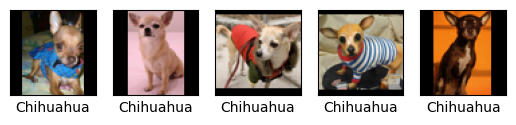

In [40]:
# Plot first 8
breeds = list(y_train[:5])
images = X_train[:5]
cols = len(breeds)
for i in range(len(breeds)):
    plt.subplot(2, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = array_to_img(images[i])
    plt.imshow(img)
    plt.xlabel(breeds[i])

plt.show();

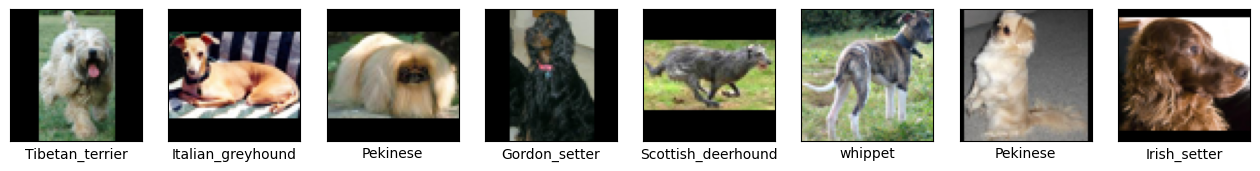

In [41]:
# Plot 8 random images
num_samples = 8
random_indices = np.random.choice(len(X_train), num_samples, replace=False)
random_images = X_train[random_indices]
random_breeds = [y_train[idx] for idx in random_indices]
cols = num_samples

plt.figure(figsize=(16, 4))
for i in range(num_samples):
    plt.subplot(1, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = array_to_img(random_images[i])
    plt.imshow(img)
    plt.xlabel(random_breeds[i])

plt.show();

In [42]:
# checking that data is as described from data source
# we should have 120 classes in both train and test dataset
unique_labels_train = np.unique(y_train, return_counts=True)
unique_labels_test = np.unique(y_test)

print(unique_labels_train)              # checking label format and # of examples per class
print(len(unique_labels_train[0]))      # checking we have 120 classes in train
print(len(unique_labels_test))          # checking we have 120 classes in test

(array(['Afghan_hound', 'African_hunting_dog', 'Airedale',
       'American_Staffordshire_terrier', 'Appenzeller',
       'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog',
       'Blenheim_spaniel', 'Border_collie', 'Border_terrier',
       'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon',
       'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever',
       'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound',
       'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog',
       'French_bulldog', 'German_shepherd', 'German_short',
       'Gordon_setter', 'Great_Dane', 'Great_Pyrenees',
       'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter',
       'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound',
       'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier',
       'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa',
       'Maltese_dog', 'Mexican_hairless', 'Newfoundland',
       'Norfolk_terri

In [43]:
# perform random stratified split on test dataset in half to get validation dataset
X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                y_test,
                                                test_size=0.5,
                                                stratify=y_test,
                                                shuffle=True,
                                                random_state=42)


print("Shape of validation images ", X_val.shape)
print("Shape of validation labels ", y_val.shape)
print("Shape of testing images ", X_test.shape)
print("Shape of testing labels ", y_test.shape)

Shape of validation images  (4290, 64, 64, 3)
Shape of validation labels  (4290,)
Shape of testing images  (4290, 64, 64, 3)
Shape of testing labels  (4290,)


In [44]:
# make labels all lowercase
y_train = np.char.lower(y_train)
y_val = np.char.lower(y_val)
y_test = np.char.lower(y_test)

print(y_train[0:5])
print(y_val[0:5])

['chihuahua' 'chihuahua' 'chihuahua' 'chihuahua' 'chihuahua']
['mexican_hairless' 'english_foxhound' 'sealyham_terrier' 'shih' 'saluki']


In [45]:
# shuffle train dataset, since it does not look shuffled
np.random.seed(42)
indices = np.random.permutation(len(X_train))

X_train = X_train[indices]
y_train = y_train[indices]

print(y_train[0:5]) # verify shuffle worked

['irish_wolfhound' 'brittany_spaniel' 'redbone' 'boxer' 'pekinese']


In [46]:
# selecting random 10 classes to train on before expanding to all 120 classes
labels = np.unique(y_train)

np.random.seed(42)
classes_subset = np.random.choice(labels, size=10, replace=False)

print(classes_subset)

['flat' 'german_short' 'american_staffordshire_terrier' 'ibizan_hound'
 'cairn' 'kerry_blue_terrier' 'maltese_dog' 'bedlington_terrier'
 'english_setter' 'sussex_spaniel']


In [47]:
# create subsetted datasets
mask_1 = np.isin(y_train, classes_subset)
mask_2 = np.isin(y_val, classes_subset)

X_train_sub = X_train[mask_1]
y_train_sub = y_train[mask_1]
X_val_sub = X_val[mask_2]
y_val_sub = y_val[mask_2]

print("Shape of training images ", X_train_sub.shape)
print("Shape of training labels ", y_train_sub.shape)
print("Shape of validation images ", X_val_sub.shape)
print("Shape of validation labels ", y_val_sub.shape)

Shape of training images  (1000, 64, 64, 3)
Shape of training labels  (1000,)
Shape of validation images  (388, 64, 64, 3)
Shape of validation labels  (388,)


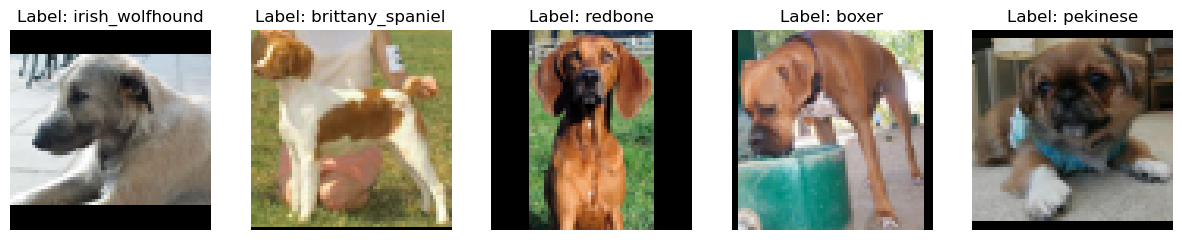

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(f"Label: {y_train[i]}")
plt.show()

In [50]:
# define preprocessing steps
preproc = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.1),
    #tf.keras.layers.RandomCrop(64, 64),
    tf.keras.layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.1)),
    tf.keras.layers.RandomContrast(0.1)
])

def augment_images_in_batches(X, y, num_augments=2, batch_size=128):
    """
    Args:
        X (np.ndarray): Original images, shape (N, 64, 64, 3)
        y (np.ndarray): Labels, shape (N,)
        num_augments (int): Number of augmentation rounds
        batch_size (int): Number of images to process at once

    Returns:
        X_all (np.ndarray), y_all (np.ndarray)
    """
    X_aug = [X]
    y_aug = [y]

    for round in range(num_augments):
        print(f"Augmenting batch {round + 1}/{num_augments}")
        X_aug_round = []
        y_aug_round = []

        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            batch = tf.convert_to_tensor(X[start:end], dtype=tf.float32)
            batch_aug = preproc(batch, training=True).numpy()
            X_aug_round.append(batch_aug)
            y_aug_round.append(y[start:end])  

        X_aug.append(np.concatenate(X_aug_round, axis=0))
        y_aug.append(np.concatenate(y_aug_round, axis=0))

    X_all = np.concatenate(X_aug, axis=0)
    y_all = np.concatenate(y_aug, axis=0)
    
    return X_all, y_all

X_train_sub_aug, y_train_sub_aug = augment_images_in_batches(X_train_sub, y_train_sub, num_augments=5, batch_size=128)
X_train_aug, y_train_aug = augment_images_in_batches(X_train, y_train, num_augments=5, batch_size=128)

Augmenting batch 1/5
Augmenting batch 2/5
Augmenting batch 3/5
Augmenting batch 4/5
Augmenting batch 5/5
Augmenting batch 1/5
Augmenting batch 2/5
Augmenting batch 3/5
Augmenting batch 4/5
Augmenting batch 5/5


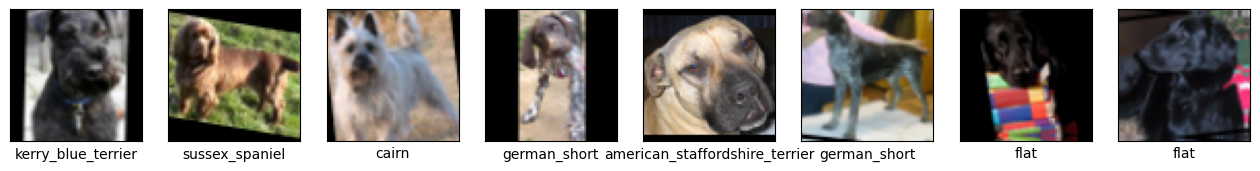

In [52]:
#after augmentation step, plot 8 random images

num_samples = 8
random_indices = np.random.choice(len(X_train_sub_aug), num_samples, replace=False)
random_images = X_train_sub_aug[random_indices]
random_breeds = [y_train_sub_aug[idx] for idx in random_indices]
cols = num_samples

plt.figure(figsize=(16, 4))
for i in range(num_samples):
    plt.subplot(1, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = array_to_img(random_images[i])
    plt.imshow(img)
    plt.xlabel(random_breeds[i])

plt.show();

In [53]:
# normalize pixel values for image data
print("Example before normalizing:", X_train_sub[10][10][10])

X_train_sub = X_train_sub / 255.0
X_val_sub = X_val_sub / 255.0

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print("Example after normalizing:", X_train_sub[10][10][10])

Example before normalizing: [103  82  66]
Example after normalizing: [0.40392157 0.32156863 0.25882353]


In [54]:
# subsetted dataset
X_train_sub = X_train_sub_aug
y_train_sub = y_train_sub_aug
print("X_train_sub is now:", X_train_sub.shape)
print("y_train_sub is now:", y_train_sub.shape)
print("X_val_sub:", X_val_sub.shape)
print("y_val_sub:", y_val_sub.shape)


# full dataset
X_train = X_train_aug
y_train = y_train_aug
print("\nX_train is now:", X_train.shape)
print("y_train is now:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train_sub is now: (6000, 64, 64, 3)
y_train_sub is now: (6000,)
X_val_sub: (388, 64, 64, 3)
y_val_sub: (388,)

X_train is now: (72000, 64, 64, 3)
y_train is now: (72000,)
X_val: (4290, 64, 64, 3)
y_val: (4290,)
X_test: (4290, 64, 64, 3)
y_test: (4290,)


In [55]:
# save processed datasets into pkl file with _bbox suffix for all keys

import pickle

save_path_1 = os.path.join(BASE_DIR, "processed/processed_sub_dataset.pkl")
save_path_2 = os.path.join(BASE_DIR, "processed/processed_full_dataset.pkl")

with open(save_path_1, "wb") as f:
    pickle.dump({
        "X_train_sub_bbox": X_train_sub,         # first train with smaller subset
        "y_train_sub_bbox": y_train_sub,         # first train with smaller subset
        "X_val_sub_bbox": X_val_sub,             # validation for smaller subset
        "y_val_sub_bbox": y_val_sub,             # validation for smaller subset
        "classes_sub_bbox": classes_subset,      # array of class names for subset
    }, f)

print("Saved to:", save_path_1)

with open(save_path_2, "wb") as f:
    pickle.dump({
        "X_train_bbox": X_train,                 # then train with all classes
        "y_train_bbox": y_train,                 # then train with all classes
        "X_val_bbox": X_val,                     # validation for all classes
        "y_val_bbox": y_val,                     # validation for all classes
        "X_test_bbox": X_test,                   # test images (all classes)
        "y_test_bbox": y_test,                   # test labels (all classes)
        "classes_bbox": labels,                  # array of all class names
    }, f)

print("Saved to:", save_path_2)

Saved to: /Users/jenny/github/mids-w207-foursigma/data/processed/processed_sub_dataset.pkl
Saved to: /Users/jenny/github/mids-w207-foursigma/data/processed/processed_full_dataset.pkl


In [ ]:
# Use this to load the new images in your wb
# # Load processed datasets with _bbox suffix for all keys

# with open("../data/processed/processed_sub_dataset.pkl", "rb") as f:
#     data_sub = pickle.load(f)
# print("Sub dataset keys:", data_sub.keys())

# with open("../data/processed/processed_full_dataset.pkl", "rb") as f:
#     data_full = pickle.load(f)
# print("Full dataset keys:", data_full.keys())

# # Assign variables for sub dataset (bbox keys)
# X_train_sub = data_sub["X_train_sub_bbox"]
# y_train_sub = data_sub["y_train_sub_bbox"]
# X_val_sub = data_sub["X_val_sub_bbox"]
# y_val_sub = data_sub["y_val_sub_bbox"]
# classes_sub = data_sub["classes_sub_bbox"]

# # Assign variables for full dataset (bbox keys)
# X_train = data_full["X_train_bbox"]
# y_train = data_full["y_train_bbox"]
# X_val = data_full["X_val_bbox"]
# y_val = data_full["y_val_bbox"]
# X_test = data_full["X_test_bbox"]
# y_test = data_full["y_test_bbox"]
# classes = data_full["classes_bbox"]

In [21]:
# use the following code to load dataset in your notebook

# with open("../data/processed/processed_sub_dataset.pkl", "rb") as f:
#     data = pickle.load(f)
# print(data.keys())

# with open("../data/processed/processed_full_dataset.pkl", "rb") as f:
#     data = pickle.load(f)
# print(data.keys())